# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.01
pole_length = 0.045
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=1500, on_iteration=on_iteration)

iteration 0 accepted 6511.902779878666 [ 0.05931982 -0.01654533  2.05466727 -7.87080505]
iteration 1 accepted 2939.2838955460006 [ 0.02840426 -0.02937585  1.87676035 -0.08892261]
iteration 2 accepted 2152.508009966051 [-0.00435734 -0.05647784  1.5019686  -3.329882  ]
iteration 3 accepted 1413.368313744392 [-0.01768297 -0.00501329  1.37785494 -3.02411583]
iteration 4 accepted 1177.321195671932 [-0.01877571  0.00544552  1.25815392 -2.87501279]
iteration 5 accepted 1082.4254312710987 [-0.01788586  0.02010368  1.1486722  -2.85538903]
iteration 6 accepted 1017.4763131339823 [-0.01721786  0.02423206  1.07966668 -2.80371907]
iteration 7 accepted 930.0744338725335 [-3.78048544e-04  9.62249811e-02  9.85568101e-01 -2.72313975e+00]
iteration 8 accepted 870.3636386745848 [ 0.00410837  0.11264458  0.91400815 -2.66155584]
iteration 9 accepted 844.8056809762198 [ 0.01454859  0.13523504  0.77450109 -2.66864199]
iteration 10 accepted 783.1824970884945 [ 0.00884181  0.0654138   0.84981114 -1.94422251]
i

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

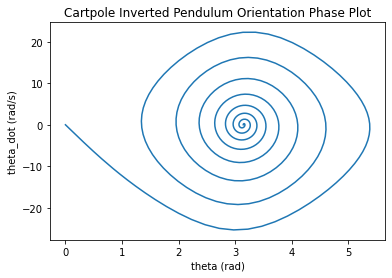

In [19]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Cartpole Inverted Pendulum Orientation Phase Plot")

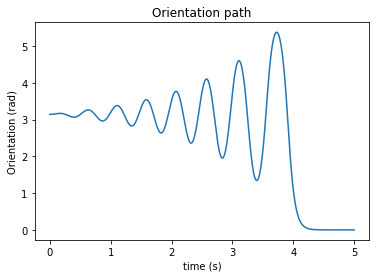

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

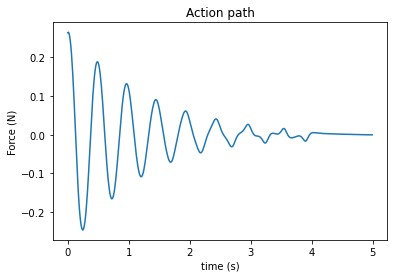

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

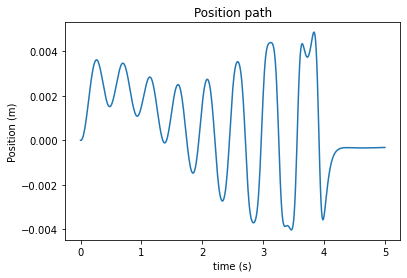

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

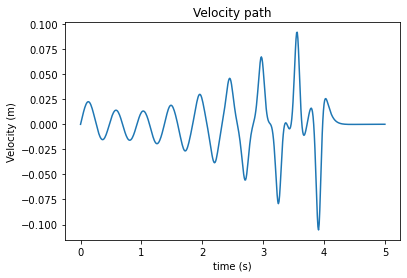

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

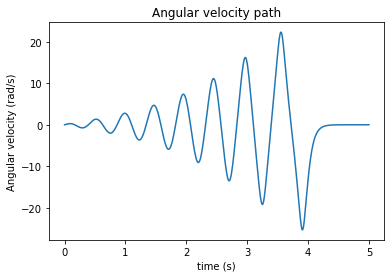

In [17]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

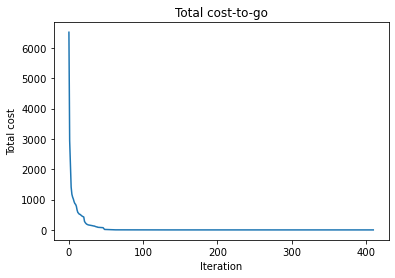

In [18]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

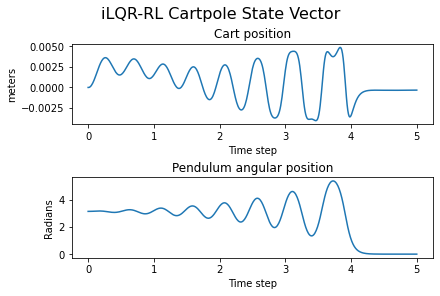

In [38]:
fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle('iLQR-RL Cartpole State Vector', fontsize=16)
#plt.figure(figsize=(100,600))

axs[0].plot(t, x)
axs[0].set_title('Cart position')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('meters')

'''
axs[1].plot(t, x_dot)
axs[1].set_title('Cart velocity')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('m/s')
'''

axs[1].plot(t, theta)
axs[1].set_title('Pendulum angular position')
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Radians')

'''
axs[3].plot(t, theta_dot)
axs[3].set_title('Pendulum angular velocity')
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Radians/sec')
'''

plt.show()
